In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [175]:
df = pd.read_csv('files/raw.csv')
df

,wx,time,pitch,wz,az,ay,yaw,ax,roll,wy
0,-5.0,1.03,4909.0,1.0,327.0,380.0,32039.0,-17.0,328.0,-5.0
1,-5.0,1.03,4909.0,1.0,327.0,380.0,32039.0,-17.0,328.0,-5.0
2,-3.0,1.05,4908.0,-4.0,325.0,379.0,32040.0,-20.0,329.0,4.0
3,1.0,1.08,4908.0,-8.0,325.0,378.0,32043.0,-16.0,332.0,8.0
4,8.0,1.10,4909.0,-2.0,325.0,379.0,32044.0,-16.0,335.0,7.0
...,...,...,...,...,...,...,...,...,...,...
1340,-2.0,17.36,5201.0,3.0,264.0,397.0,35774.0,160.0,-3138.0,-3.0
1341,3.0,17.38,5201.0,2.0,265.0,400.0,35774.0,161.0,-3138.0,1.0
1342,4.0,17.39,5201.0,1.0,263.0,400.0,35773.0,161.0,-3138.0,4.0
1343,4.0,17.40,5202.0,0.0,262.0,398.0,35773.0,161.0,-3138.0,4.0


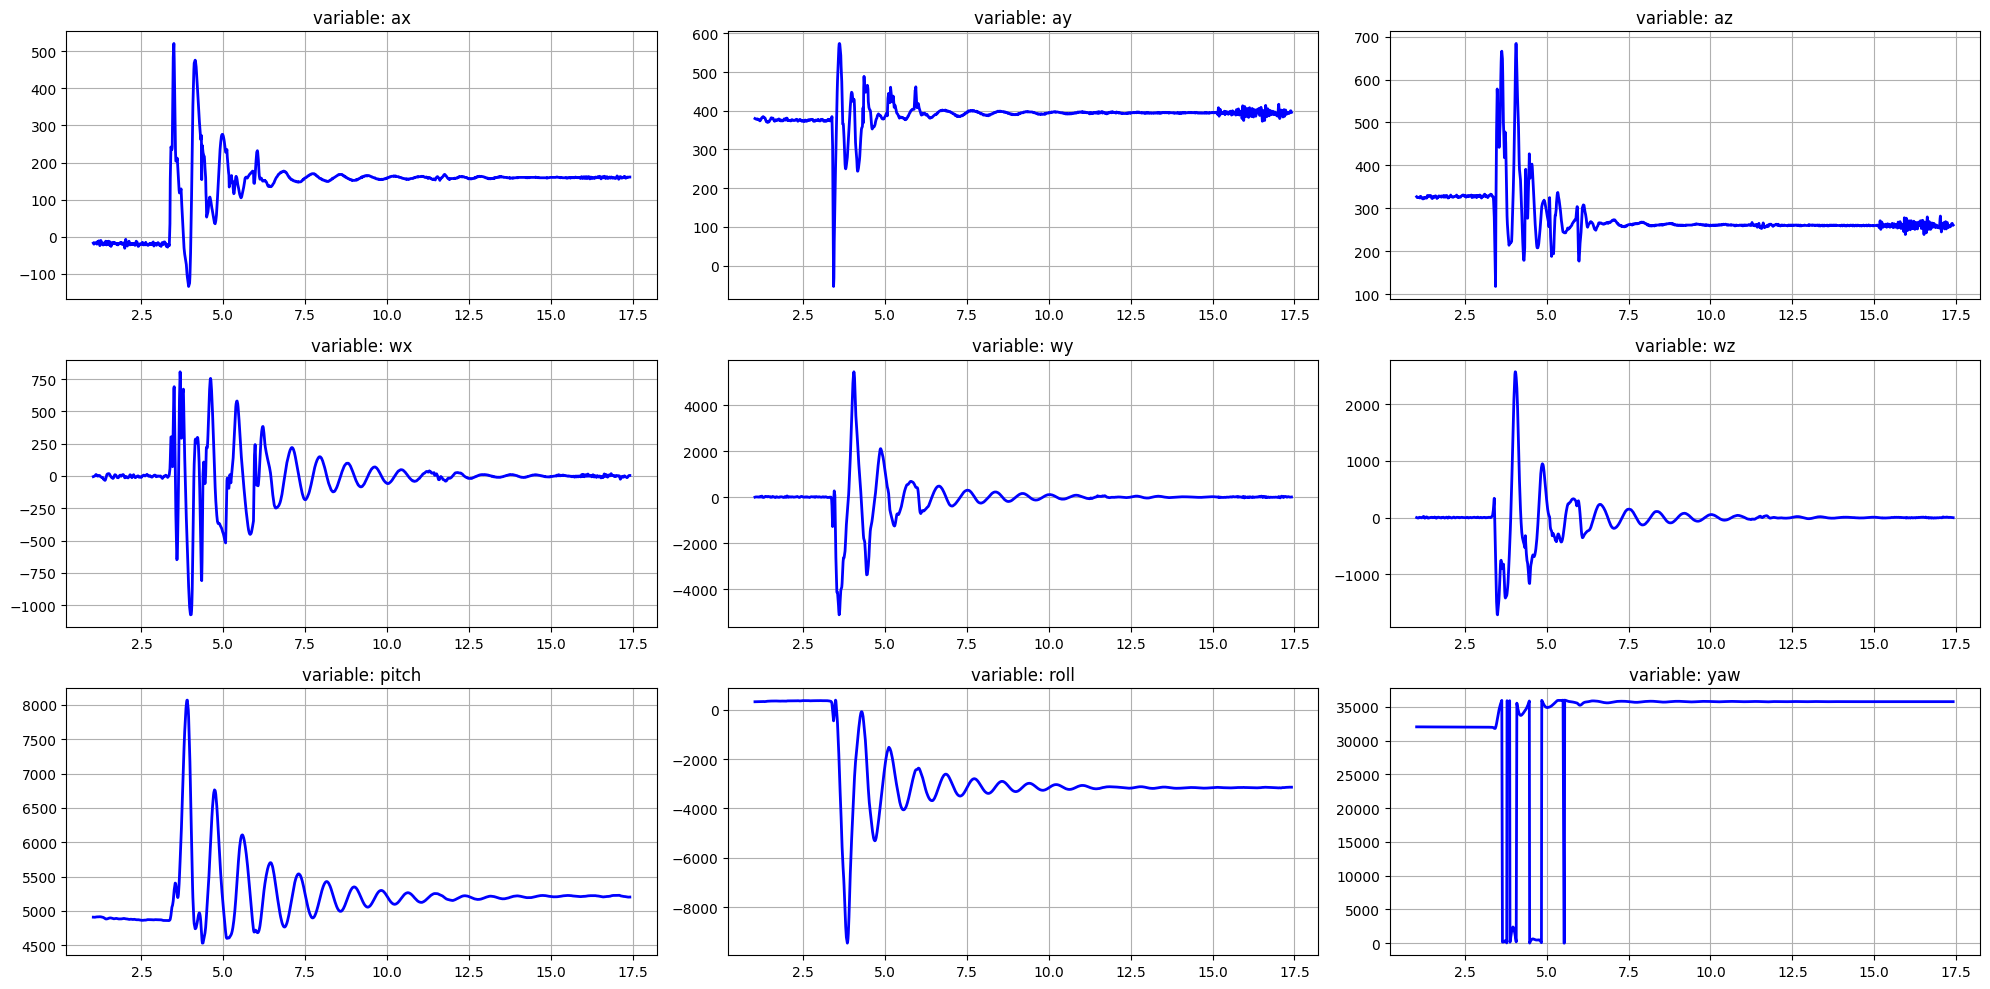

In [176]:
def plotAll(df, time, limits=None):
    target = df.copy() if not limits else df.loc[(df.time >= limits[0]) & (df.time <= limits[1])]

    plt.figure(figsize=(20, 10))
    for i, key in enumerate(['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'pitch', 'roll', 'yaw']):
        plt.subplot(3, 3, i+1)
        plt.plot(time, target[key], color='blue', linewidth=2)
        plt.title(f'variable: {key}'), plt.grid()

    plt.tight_layout()
    plt.show()


plotAll(df, df.time, limits=None)

# NORMALIZANDO AMOSTRAGEM

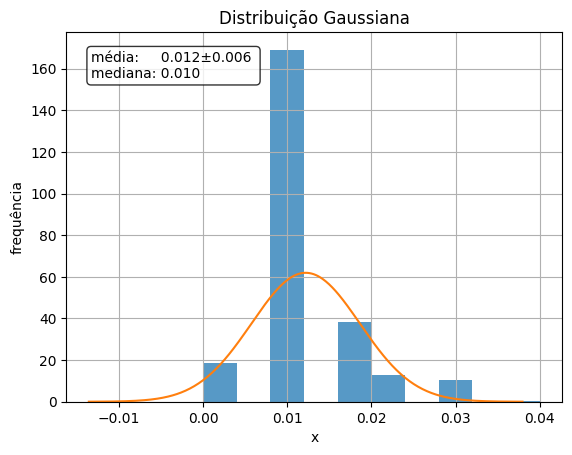

In [177]:
def gaussian(data):
    data  = np.array(data)
    n     = data.shape[0]
    mu    = data.mean()
    sigma = data.std()

    x  = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)
    y  = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu)/sigma)**2)
    plt.title(f'Distribuição Gaussiana')
    plt.hist(data, density=True, alpha=0.75)
    plt.plot(x, y)
    
    text = f'média:     {mu:.3f}±{sigma:.3f} \nmediana: {np.median(data):.3f}'
    opts = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=opts)
    plt.xlabel('x'); plt.ylabel('frequência'); plt.grid()


gaussian(df.time.diff()[1:].to_numpy())

,time,wx,pitch,wz,az,ay,yaw,ax,roll,wy
0,0.00,-5.0,4909.0,1.0,327.0,380.0,32039.0,-17.0,328.0,-5.0
1,0.01,-5.0,4909.0,1.0,327.0,380.0,32039.0,-17.0,328.0,-5.0
2,0.02,-5.0,4909.0,1.0,327.0,380.0,32039.0,-17.0,328.0,-5.0
3,0.03,-3.0,4908.0,-4.0,325.0,379.0,32040.0,-20.0,329.0,4.0
4,0.04,-3.0,4908.0,-4.0,325.0,379.0,32040.0,-20.0,329.0,4.0
...,...,...,...,...,...,...,...,...,...,...
1635,16.35,3.0,5201.0,2.0,265.0,400.0,35774.0,161.0,-3138.0,1.0
1636,16.36,4.0,5201.0,1.0,263.0,400.0,35773.0,161.0,-3138.0,4.0
1637,16.37,4.0,5202.0,0.0,262.0,398.0,35773.0,161.0,-3138.0,4.0
1638,16.38,4.0,5202.0,-1.0,261.0,396.0,35773.0,161.0,-3138.0,3.0


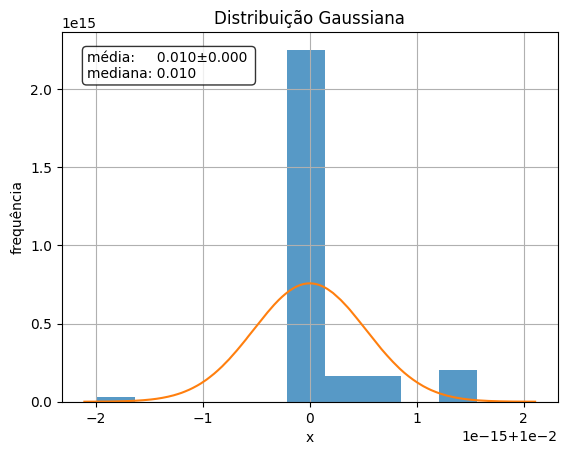

In [178]:
def normalizeTable(df, key, dt=0.15):
    df = df.copy().sort_values(key)
    df[key] = df[key] - df[key].iloc[0]

    initTime  = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    n = int(np.floor((finalTime - initTime) / dt)) + 1
    newAxis = np.round(np.linspace(initTime, initTime + dt*(n-1), n), 10)

    target = pd.DataFrame({key: newAxis})
    # direction='backward' equivale ao ffill no reindex
    out = pd.merge_asof(target, df, on=key, direction='backward')
    return out



dt = 0.01
df = normalizeTable(df, 'time', dt)

display(df)
gaussian(df.time.diff()[1:].to_numpy())

# APLICANDO 

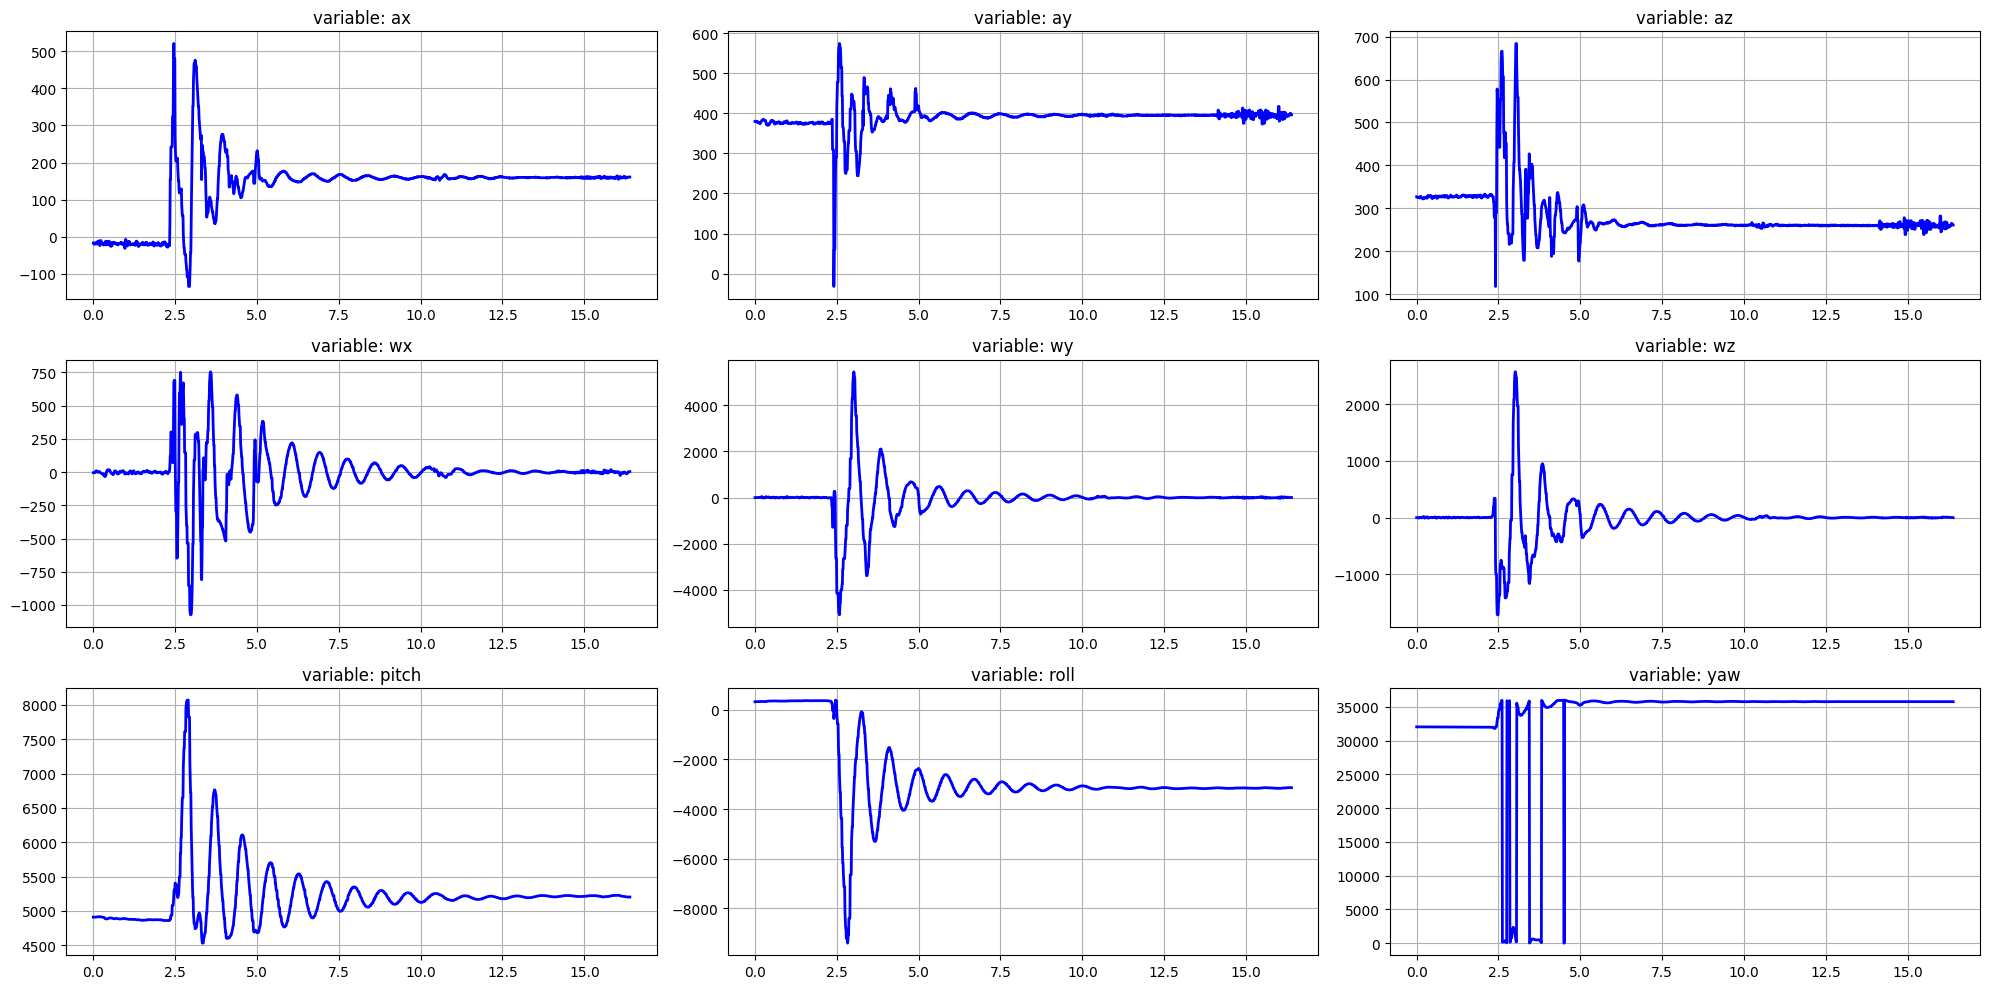

In [179]:
time = df.time.values
df   = df.drop(columns=['time'])
plotAll(df, time, limits=None)

# VALORES PASSADOS

In [ ]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}'] = table[key]

    for i in range(1, n):
        table[f'{var}(n-{i})'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}'] + [f'{var}(n-{i})' for i in range(1, n)]
    return table[columns]


N_STATES = 50
getStates(df, 'ax', var='ax', n=N_STATES)

,ax,ax(n-1),ax(n-2),ax(n-3),ax(n-4)
0,-17.0,0.0,0.0,0.0,0.0
1,-17.0,-17.0,0.0,0.0,0.0
2,-17.0,-17.0,-17.0,0.0,0.0
3,-20.0,-17.0,-17.0,-17.0,0.0
4,-20.0,-20.0,-17.0,-17.0,-17.0
...,...,...,...,...,...
1635,161.0,160.0,160.0,160.0,160.0
1636,161.0,161.0,160.0,160.0,160.0
1637,161.0,161.0,161.0,160.0,160.0
1638,161.0,161.0,161.0,161.0,160.0


In [182]:
target = pd.DataFrame()

for column in df.columns:
    states = getStates(df, column, var=column, n=N_STATES)
    target = pd.concat([target, states], axis=1)

target

,wx,wx(n-1),wx(n-2),wx(n-3),wx(n-4),wx(n-5),wx(n-6),wx(n-7),wx(n-8),wx(n-9),...,wy(n-40),wy(n-41),wy(n-42),wy(n-43),wy(n-44),wy(n-45),wy(n-46),wy(n-47),wy(n-48),wy(n-49)
0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.0,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.0,-3.0,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,-10.0,-7.0,-7.0,...,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0,-10.0,-10.0,-11.0
1636,4.0,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,-10.0,-7.0,...,-19.0,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0,-10.0,-10.0
1637,4.0,4.0,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,-10.0,...,-16.0,-19.0,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0,-10.0
1638,4.0,4.0,4.0,3.0,-2.0,-2.0,-7.0,-10.0,-12.0,-13.0,...,-16.0,-16.0,-19.0,-8.0,-8.0,-10.0,-10.0,-2.0,-2.0,-10.0


In [ ]:
if False:
    target = pd.DataFrame()

    for column in ['ax', 'ay', 'az', 'wx', 'wy', 'wz']:
        states = getStates(df, column, var=column, n=N_STATES)
        target = pd.concat([target, states], axis=1)

    target['pitch'] = df['pitch']
    target

In [183]:
target.to_csv('files/DataBase.csv', index=None)